# <center>Домашняя работа по лекции 16
### Задание:
Опираясь на табличное обучение с подкреплением реализовать и обучить нейронную Q-функцию.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Copied from https://github.com/neilslater/game_playing_scripts

'''
   Copyright 2017 Neil Slater

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
'''

import numpy as np
import random

class TicTacToeGame():
    def __init__(self):
        self.state = '         '
        self.player = 'X'
        self.winner = None

    def allowed_moves(self):
        states = []
        for i in range(len(self.state)):
            if self.state[i] == ' ':
                states.append(self.state[:i] + self.player + self.state[i+1:])
        return states
    
    def allowed_moves_numbers(self):
        numbers = []
        for i in range(len(self.state)):
            if self.state[i] == ' ':
                numbers.append(i)
        return numbers

    def make_move(self, next_state):  # или ход привел к чьей-то победе, или переход хода
        if self.winner:
            raise(Exception("Game already completed, cannot make another move!"))
        if not self.__valid_move(next_state):
            raise(Exception("Cannot make move {} to {} for player {}".format(
                    self.state, next_state, self.player)))

        self.state = next_state
        self.winner = self.predict_winner(self.state)
        if self.winner:
            self.player = None
        elif self.player == 'X':
            self.player = 'O'
        else:
            self.player = 'X'

    def playable(self):
        return ( (not self.winner) and any(self.allowed_moves()) )  # победителя еще нет и есть доступные ходы

    def predict_winner(self, state):
        lines = [(0,1,2), (3,4,5), (6,7,8), (0,3,6), (1,4,7), (2,5,8), (0,4,8), (2,4,6)]
        winner = None
        for line in lines:
            line_state = state[line[0]] + state[line[1]] + state[line[2]]
            if line_state == 'XXX':
                winner = 'X'
            elif line_state == 'OOO':
                winner = 'O'
        return winner

    def __valid_move(self, next_state):
#         allowed_moves = self.allowed_moves()
        allowed_moves = self.allowed_moves()
        if any(state == next_state for state in allowed_moves):
            return True
        return False

    def print_board(self):
        s = self.state
        print('     {} | {} | {} '.format(s[0],s[1],s[2]))
        print('    -----------')
        print('     {} | {} | {} '.format(s[3],s[4],s[5]))
        print('    -----------')
        print('     {} | {} | {} '.format(s[6],s[7],s[8]))


In [4]:
class MyDebugException(Exception):
        """Пользовательское исключение."""

In [47]:
class Agent():
    def __init__(self, game_class, Model, Criterion, epsilon=0.1, 
                 lr=0.001, gamma=1.0, q_delta=0.02, player_mark='X', second_player_mark='O', epoch_size=1000, batch_size=100):
        self.Q = Model().to(device)
        self.NewGame = game_class
        self.epsilon = epsilon
        self.criterion = Criterion()
        self.optimizer = torch.optim.Adadelta(self.Q.parameters())
        self.player_mark = player_mark
        self.second_player_mark = second_player_mark
        self.gamma = gamma
        self.q_delta = q_delta
        self.losses = {'X': [], 'O': []}
        self.total_episode = 0
        self.history = None
        self.batches = None
        self.epoch_size = epoch_size
        self.batch_size = batch_size
        self.player = None
        
        self.history_reset()

    
    def history_reset(self):
        self.history = {'state': [], 'move': [], 'reward': []}
    
    @staticmethod
    def stateact_totensor(state):
        sign_to_value = {"X": 1.0, "O": -1.0, " ": 0.0}
        tensor = torch.FloatTensor([sign_to_value[item] for item in state]).requires_grad_(True).view(1, len(state)).to(device)
        return tensor

    def Q_func(self, game_state, Q_freezed=None):
        Q = Q_freezed or self.Q
        if game_state is not None:
            Q_func = Q(self.stateact_totensor(game_state))
        else:
            Q_func = torch.FloatTensor([[0.] * 9]).requires_grad_(True).view(1, -1).to(device)
        return Q_func[0]

    def learn_game(self, num_episodes=1000, reset=False):
        if reset:
            self.Q = Model().to(device)
            self.total_episode = 0
            self.history_reset()
        for episode in range(num_episodes):
            self.learn_from_episode()
            self.total_episode += 1

    def learn_from_episode(self):
        game = self.NewGame()
        _, move = self.learn_select_move(game.state, game)  # выбираем начальный ход (учитываем заданное правило)
        while move is not None:
            move = self.learn_from_move(game, move)
        if self.total_episode % self.epoch_size == 0 and self.total_episode > 0:
#             raise(MyDebugException)
            self.process_learning()
            self.history_reset()
    
    def _batching(self):
        self.batches = {'X': [], 'O': []}
        batch = {'X': [], 'O': []}
        loc_count = 0
        for i in range(len(self.history['move']) - 1):
            state = self.history['state'][i]
            move = self.history['move'][i]
            r = self.history['reward'][i+1]
            next_state = None
#             if self.history['state'][i + 2].count('X') not in [0, 1] or self.history['state'][i + 2].count('O') == 1:
            next_state = self.history['state'][i + 1]
            if state == ' ' * 9:
                loc_count = 0
            if loc_count % 2 == 0:
                batch['X'].append([state, move, r, next_state])
                loc_count += 1
            else:
                batch['O'].append([state, move, r, next_state])
                loc_count += 1
            if (i + 1) % self.batch_size == 0:
                self.batches['X'].append(batch['X'])
                self.batches['O'].append(batch['O'])
                batch = {'X': [], 'O': []}
        return self.batches
            
    def process_learning(self):
        """update policy table based on latest game"""
        self._batching()
#         raise(MyDebugException)
        for player in self.batches:
            self.player = player
            Q_freezed = copy.deepcopy(self.Q).requires_grad_(False)
            for batch in self.batches[player]:
                loss = 0
                for state, move, r, next_state in batch:
                    current_Q = self.Q_func(state)
#                     with torch.no_grad():
                    next_Q = self.Q_func(next_state, Q_freezed)
                    r_tensor = torch.zeros_like(next_Q)
                    r_tensor[move] = r
                    td_target = r_tensor + self.gamma * next_Q
    #                 self.debugvalues = [current_Q, next_Q, r]
    #                 raise(MyDebugException)
                    loss += self.criterion(current_Q, td_target)
    #                 print(loss)
    #                 print(((current_Q - td_target)**2).sum())
    #                 raise(MyDebugException)

                loss /= len(batch)
                # обучаем сеть
                self.Q.zero_grad()
                self.losses[player].append(loss.data.item())
                loss.backward()
                # делаем шаг в сторону улучшения модели
                self.optimizer.step()
    
    @staticmethod
    def get_move_str(move, game):
        move_str = list(game.state)
        move_str[move] = game.player
        move_str = ''.join(move_str)
        return move_str
    
    def learn_from_move(self, game, move):
        self.history['state'].append(game.state)
        self.history['move'].append(move)
        
        move_str = self.get_move_str(move, game)
        game.make_move(move_str)  # проверяет, есть ли победитель в game.winner, и если нет - переход хода
        r = self.__reward(game)  # вычисляем вознаграждение за ход move
        selected_next_move = None
        if game.playable():  # победителя еще нет и есть доступные ходы
            best_next_move, selected_next_move = self.learn_select_move(move_str, game)  
            
#         self.history['states'].append(move)
        self.history['reward'].append(r) 
#         self.history['next_state'].append(game.state)
#         self.history['next_move'].append(selected_next_move) 

        return selected_next_move

    def learn_select_move(self, current_state, game):
        allowed_move_Q_func = self.__Q_func(current_state, game.allowed_moves_numbers())  # словарь состояние-значение
        if game.player == self.player_mark:
            self.player = self.player_mark
            best_move = self.__argmax_Q(allowed_move_Q_func)
        else:
            self.player = self.second_player_mark
            best_move = self.__argmin_Q(allowed_move_Q_func)

        selected_move = best_move
        if random.random() < self.epsilon:   # добавляем случайный ход (здесь - в 10%, согласно epsilon)
            selected_move = self.__random_Q(allowed_move_Q_func)

        return (best_move, selected_move)

    def play_select_move(self, move, game):
        if game.player == self.player_mark:
            self.player = self.player_mark
            allowed_state_values = self.__Q_func(game.state, game.allowed_moves_numbers())  # словарь с доступными ходами и их values
            return self.__argmax_Q(allowed_state_values)  # выбираем наулучших ход для player_mark
        else:
            # ходит "не player_mark": выбираем наулучших ход для "не player_mark" (== наихудший для player_mark)
            self.player = self.second_player_mark
            allowed_state_values = self.__Q_func(game.state, game.allowed_moves_numbers())  # словарь с доступными ходами и их values
            return self.__argmin_Q(allowed_state_values)  
    
    def demo_game(self, verbose=False):
        game = self.NewGame()
        t = 0
        state = game.state
        while game.playable():  # пока нет победителя и есть доступные ходы
            if verbose:
                print(" \nTurn {}\n".format(t))
                game.print_board()
            move = self.play_select_move(state, game)
            move_str = self.get_move_str(move, game)
            game.make_move(move_str)  # или ход привел к чьей-то победе, или переход хода
            t += 1
        if verbose:
            print(" \nTurn {}\n".format(t))
            game.print_board()
        if game.winner:
            if verbose:
                print("\n{} is the winner!".format(game.winner))
            return game.winner
        else:
            if verbose:
                print("\nIt's a draw!")
            return '-'

    def interactive_game(self, agent_player='X', human_player='O'):
        game = self.NewGame()
        t = 0
        move = game.state
        while game.playable():
            print(" \nTurn {}\n".format(t))
            game.print_board()
            if game.player == agent_player:
                self.player = agent_player
                move = self.play_select_move(move, game)  # делаем ход (выбранное новое состояние)
                move_str = self.get_move_str(move, game)
                game.make_move(move_str)
            else:
                self.player = human_player
                move = self.__request_human_move(game)
                move_str = self.get_move_str(move, game)
                game.make_move(move_str)
            t += 1

        print(" \nTurn {}\n".format(t))
        game.print_board()

        if game.winner:
            print("\n{} is the winner!".format(game.winner))
            return game.winner
        print("\nIt's a draw!")
        return '-'

    def __Q_func(self, current_state, game_moves):
        Q = self.Q_func(current_state)
#         print("Q", Q)
#         print("game_moves", game_moves)
#         print(game_moves[0], Q[game_moves[0]])
#         raise(MyDebugException)
        return dict((move, Q[move]) for move in game_moves)

    def __argmax_Q(self, allowed_move_Q_func):
        max_Q = max(allowed_move_Q_func.values())
#         print("allowed_move_Q_func.values()", allowed_move_Q_func.values(), "max_Q", max_Q)
#         raise(MyDebugException)
        chosen_state = random.choice([move for move, q in allowed_move_Q_func.items() if q >= max_Q - self.q_delta])
        return chosen_state

    def __argmin_Q(self, allowed_move_Q_func):
        min_Q = min(allowed_move_Q_func.values())
        chosen_state = random.choice([move for move, q in allowed_move_Q_func.items() if q <= min_Q + self.q_delta])
        return chosen_state

    def __random_Q(self, allowed_move_Q_func):
        return random.choice(list(allowed_move_Q_func.keys()))

    def __reward(self, game):
        if game.winner == self.player_mark:
            return 1.0
        elif game.winner:
            return -1.0
        else:
            return 0.0

    def __request_human_move(self, game):
#         allowed_moves = [i+1 for i in range(9) if game.state[i] == ' ']
        allowed_moves = [i+1 for i in range(9) if game.state[i] == ' ']
        human_move = None
        while human_move is None:
            idx = int(input('Choose move for {}, from {} : '.format(game.player, allowed_moves)))
            if any([i==idx for i in allowed_moves]):
#                 human_move = game.state[:idx-1] + game.player + game.state[idx:]
                human_move = idx - 1
        return human_move
        

In [6]:
class QModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 50) 
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 50)
        self.fc5 = nn.Linear(50, 9)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        x = torch.tanh(x)
        return x

In [7]:
def demo_game_stats(agent):
    games_num = 1000
    results = [agent.demo_game() for i in range(games_num)]
    game_stats = {k: round(results.count(k) / games_num * 100, 1) for k in ['X', 'O', '-']}
    print("    percentage results: {}".format(game_stats))

In [48]:
%%time

agent = Agent(TicTacToeGame, Model=QModel, Criterion=nn.MSELoss, epsilon=0.1, q_delta=0.03, gamma=1.0)
total_episodes = 0
print("Before learning:")
demo_game_stats(agent)

num_episodes = 5_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

Before learning:
    percentage results: {'X': 17.5, 'O': 82.5, '-': 0.0}
After 5000 learning games:
    percentage results: {'X': 45.6, 'O': 35.4, '-': 19.0}
Wall time: 1min 57s


In [54]:
%%time
num_episodes = 5_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

After 10000 learning games:
    percentage results: {'X': 28.2, 'O': 8.4, '-': 63.4}
Wall time: 2min 22s


In [62]:
%%time
num_episodes = 10_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

After 20000 learning games:
    percentage results: {'X': 0.0, 'O': 0.0, '-': 100.0}
Wall time: 4min 47s


In [20]:
%%time
num_episodes = 10_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

After 20000 learning games:
    percentage results: {'X': 100.0, 'O': 0.0, '-': 0.0}
Wall time: 3min 38s


In [63]:
%%time
num_episodes = 10_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

After 40000 learning games:
    percentage results: {'X': 79.9, 'O': 17.3, '-': 2.8}
Wall time: 1min 32s


In [68]:
%%time
num_episodes = 10_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

After 50000 learning games:
    percentage results: {'X': 77.4, 'O': 20.6, '-': 2.0}
Wall time: 1min 35s


In [74]:
%%time
num_episodes = 10_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

After 60000 learning games:
    percentage results: {'X': 83.3, 'O': 15.1, '-': 1.6}
Wall time: 1min 36s


In [81]:
%%time
num_episodes = 10_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

After 70000 learning games:
    percentage results: {'X': 82.2, 'O': 15.4, '-': 2.4}
Wall time: 1min 34s


## Loss function

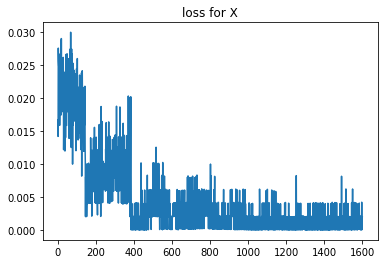

In [63]:
player = 'X'
plt.plot(agent.losses[player])
plt.title(f"loss for {player}");

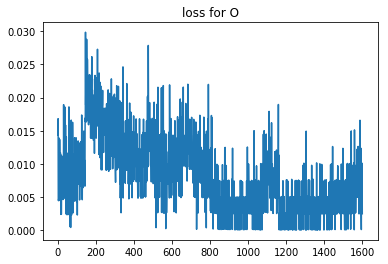

In [64]:
player = 'O'
plt.plot(agent.losses[player])
plt.title(f"loss for {player}");

In [65]:
# agent.batches['X'][0]

## Посмотрим, как обучился первый ход для **X**

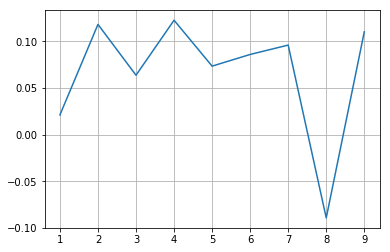

In [66]:
init_state = ' ' * 9
with torch.no_grad():
    move_values = agent.Q_func(init_state)
plt.plot(range(1, len(move_values)+1), move_values.data)
plt.grid()

**Резюме:** первый ход обучился **правильно** (по центру, см. 5 строку). Плюс у угловых ходов приоритет выше, что оптимальнее.

## Посмотрим, как обучился первый ход для **О** (при первом ходе Х по центру)

"    X    "


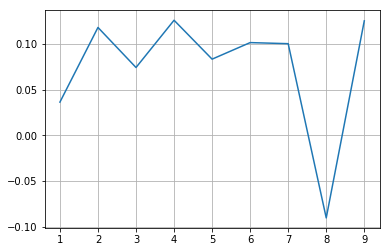

In [67]:
state = ' ' * 4 + 'X' + ' ' * 4
with torch.no_grad():
    move_values = agent.Q_func(state)
plt.plot(range(1, len(move_values)+1), move_values.data)
plt.grid()
print(f'"{state}"')

**Резюме:** первый ход для **О** обучился **правильно** (в угол, см. строку 9). кроме того, все угловые ходы имеют более высокий приоритет (с учетом того, что для **О** мы вибираем по минимуму), что как раз оптимальнее.

## Посмотрим Value для некторых комбинаций и сравним с тем, что должно быть

#### посмотрим батч, чтобы взять выигрышные, проигрышные и ничейные комбинации для проверок

In [34]:
'     '.count('X')

0

In [70]:
agent.batches['X'][0]

[['         ', 8, 0.0, '        X'],
 ['       OX', 3, 0.0, '   X   OX'],
 ['O  X   OX', 1, 0.0, 'OX X   OX'],
 ['OX X O OX', 2, 0.0, 'OXXX O OX'],
 ['OXXX OOOX', 4, 0.0, '         '],
 ['         ', 8, 0.0, '        X'],
 ['      O X', 2, 0.0, '  X   O X'],
 ['  X   OOX', 1, 0.0, ' XX   OOX'],
 ['OXX   OOX', 4, -1.0, 'OXX X OOX'],
 ['         ', 3, 0.0, '   X     '],
 ['   X   O ', 8, 0.0, '   X   OX'],
 ['O  X   OX', 1, 0.0, 'OX X   OX'],
 ['OX XO  OX', 6, 0.0, 'OX XO XOX'],
 ['OXOXO XOX', 5, 0.0, '         '],
 ['         ', 1, 0.0, ' X       '],
 [' X     O ', 5, 0.0, ' X   X O '],
 ['OX   X O ', 2, 0.0, 'OXX  X O '],
 ['OXX  XOO ', 4, -1.0, 'OXX XXOO '],
 ['         ', 8, 0.0, '        X'],
 ['       OX', 1, 0.0, ' X     OX'],
 ['OX     OX', 3, 0.0, 'OX X   OX'],
 ['OX X O OX', 6, 0.0, 'OX X OXOX'],
 ['OX XOOXOX', 2, 0.0, '         '],
 ['         ', 6, 0.0, '      X  '],
 ['      XO ', 3, 0.0, '   X  XO '],
 [' O X  XO ', 8, 0.0, ' O X  XOX'],
 ['OO X  XOX', 2, -1.0, 'OOXX  XOX']

In [26]:
for item in agent.batches[1]:
    if item[4] is None:
        with torch.no_grad():
            print("reward / calculated reward by Q_func:\t", item[2], "/", (agent.Q_func(item[0]), 4))

KeyError: 1

**Резюме:** **все** выигрыши, проигрыши и ничьи определены **верно**.

## demo game

In [68]:
agent.demo_game(True)

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
     X |   |   
    -----------
       |   |   
 
Turn 2

       |   |   
    -----------
     X |   |   
    -----------
       | O |   
 
Turn 3

       |   |   
    -----------
     X |   |   
    -----------
       | O | X 
 
Turn 4

     O |   |   
    -----------
     X |   |   
    -----------
       | O | X 
 
Turn 5

     O |   |   
    -----------
     X |   |   
    -----------
     X | O | X 
 
Turn 6

     O |   | O 
    -----------
     X |   |   
    -----------
     X | O | X 
 
Turn 7

     O | X | O 
    -----------
     X |   |   
    -----------
     X | O | X 
 
Turn 8

     O | X | O 
    -----------
     X | O |   
    -----------
     X | O | X 
 
Turn 9

     O | X | O 
    -----------
     X | O | X 
    -----------
     X | O | X 

It's a draw!


'-'

## Несколько игр с агентом вручную для проверки стандартных комбинаций

In [69]:
agent.interactive_game()

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       |   |   
    -----------
       |   | X 


Choose move for O, from [1, 2, 3, 4, 5, 6, 7, 8] :  1


 
Turn 2

     O |   |   
    -----------
       |   |   
    -----------
       |   | X 
 
Turn 3

     O | X |   
    -----------
       |   |   
    -----------
       |   | X 


Choose move for O, from [3, 4, 5, 6, 7, 8] :  4


 
Turn 4

     O | X |   
    -----------
     O |   |   
    -----------
       |   | X 
 
Turn 5

     O | X |   
    -----------
     O |   |   
    -----------
     X |   | X 


Choose move for O, from [3, 5, 6, 8] :  5


 
Turn 6

     O | X |   
    -----------
     O | O |   
    -----------
     X |   | X 
 
Turn 7

     O | X | X 
    -----------
     O | O |   
    -----------
     X |   | X 


Choose move for O, from [6, 8] :  6


 
Turn 8

     O | X | X 
    -----------
     O | O | O 
    -----------
     X |   | X 

O is the winner!


'O'

In [85]:
agent.interactive_game()

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       | X |   
    -----------
       |   |   


Choose move for O, from [1, 2, 3, 4, 6, 7, 8, 9] :  2


 
Turn 2

       | O |   
    -----------
       | X |   
    -----------
       |   |   
 
Turn 3

       | O |   
    -----------
       | X |   
    -----------
       |   | X 


Choose move for O, from [1, 3, 4, 6, 7, 8] :  1


 
Turn 4

     O | O |   
    -----------
       | X |   
    -----------
       |   | X 
 
Turn 5

     O | O | X 
    -----------
       | X |   
    -----------
       |   | X 


Choose move for O, from [4, 6, 7, 8] :  7


 
Turn 6

     O | O | X 
    -----------
       | X |   
    -----------
     O |   | X 
 
Turn 7

     O | O | X 
    -----------
       | X | X 
    -----------
     O |   | X 

X is the winner!


'X'

In [86]:
agent.interactive_game()

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       | X |   
    -----------
       |   |   


Choose move for O, from [1, 2, 3, 4, 6, 7, 8, 9] :  8


 
Turn 2

       |   |   
    -----------
       | X |   
    -----------
       | O |   
 
Turn 3

       |   |   
    -----------
       | X |   
    -----------
       | O | X 


Choose move for O, from [1, 2, 3, 4, 6, 7] :  1


 
Turn 4

     O |   |   
    -----------
       | X |   
    -----------
       | O | X 
 
Turn 5

     O |   | X 
    -----------
       | X |   
    -----------
       | O | X 


Choose move for O, from [2, 4, 6, 7] :  6


 
Turn 6

     O |   | X 
    -----------
       | X | O 
    -----------
       | O | X 
 
Turn 7

     O |   | X 
    -----------
       | X | O 
    -----------
     X | O | X 

X is the winner!


'X'

**Резюме:** агент играет **оптимально**

## Вывод:
Агент явно обучился. Об этом говорит следующее:
- расчет обученным агентом значения **Q_func** для **первого хода Х** - оптимальный уверенно по центру
- **первый ход O** тоже обучился правильно. Более того, **все** оптимальные первые ходы нолика (угловые) тоже более приоритетны по Q_func (с учетом того, что для ноликов мы выбираем по минимуму).
- выборочные проверки вычисления значений **Q_func** некоторых **заранее известных** состояний  (выигрышей, проигрышей и ничьих) - все расчитано правильно. 
- а также несколько сыгранных с агентом игр. Агент играл каждый раз оптимально.   
- Лосс уменьшается в процессе обучения   
- Результат на демо: итоговый **percentage results: {'X': 0.0, 'O': 0.0, '-': 100.0}**. Динамика обучения по **percentage results** хорошо видна и наглядна.   
   
**Итого:** агент обучился правильно.